<a href="https://colab.research.google.com/github/enitin-agarwal/azureforaws/blob/master/ChurnGuardAIProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""
File: data_generator.py
Desc: Generates sophisticated, persona-based synthetic customer data
      for the ChurnGuard AI project. This script provides the
      "evidence" for the synthetic data evaluation.
"""

import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from pathlib import Path

# --- Configuration ---
NUM_CUSTOMERS = 200
SIMULATION_DAYS = 90
OUTPUT_DIR = Path("./churn_data")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Customer Personas ---
# Defines the *latent* (hidden) behavior of different customer types.
CUSTOMER_PERSONAS = {
    "loyalist": {
        "base_churn_propensity": 0.05,
        "purchase_value_mean": 150,
        "purchase_value_std": 30,
        "review_sentiment": 0.7, # (0=neg, 1=pos)
        "support_ticket_freq": 0.1,
        "login_freq_mean": 12, # hours/week
        "frustration_sensitivity": 0.2 # How much a bad event increases churn risk
    },
    "price_sensitive_newbie": {
        "base_churn_propensity": 0.4,
        "purchase_value_mean": 40,
        "purchase_value_std": 10,
        "review_sentiment": 0.4,
        "support_ticket_freq": 0.3,
        "login_freq_mean": 5,
        "frustration_sensitivity": 0.6
    },
    "disappointed_power_user": {
        "base_churn_propensity": 0.2,
        "purchase_value_mean": 250,
        "purchase_value_std": 50,
        "review_sentiment": 0.3,
        "support_ticket_freq": 0.5, # High support usage
        "login_freq_mean": 20,
        "frustration_sensitivity": 0.8
    },
    "silent_churner": {
        "base_churn_propensity": 0.3,
        "purchase_value_mean": 70,
        "purchase_value_std": 20,
        "review_sentiment": 0.5, # Tends to not leave reviews
        "support_ticket_freq": 0.05, # Doesn't complain
        "login_freq_mean": 8,
        "frustration_sensitivity": 0.5
    }
}

# --- Text Generation Templates ---
REVIEW_TEMPLATES = {
    "positive": [
        "Absolutely love this! Best purchase I've made all year.",
        "Works perfectly, exactly as described. 5 stars.",
        "Great value and fast shipping. Will buy from here again.",
        "Fantastic product. Highly recommended.",
        "My new favorite thing. So happy with this."
    ],
    "neutral": [
        "It's okay. Does the job but wasn't amazing.",
        "Product is as described. Shipping was a bit slow.",
        "Average quality for an average price. It's fine.",
        "No complaints, but not thrilled either.",
        "The item is functional."
    ],
    "negative": [
        "Extremely frustrated. Arrived broken and support is no help.",
        "This is not what I ordered! Awful quality.",
        "Waited 3 weeks for this? What a joke. Never again.",
        "Doesn't work. Complete waste of money. Trying to get a refund.",
        "Terrible experience. The website is confusing and support is useless."
    ]
}

def generate_review_text(sentiment_score, urgency):
    """Generates a review based on a sentiment score and urgency."""
    if urgency > 8:
        return random.choice(REVIEW_TEMPLATES["negative"])
    if sentiment_score > 0.6:
        return random.choice(REVIEW_TEMPLATES["positive"])
    if sentiment_score < 0.3:
        return random.choice(REVIEW_TEMPLATES["negative"])
    return random.choice(REVIEW_TEMPLATES["neutral"])

def simulate_customer_journey():
    """Simulates the full journey for all customers."""

    customers_data = []
    interactions_data = []
    reviews_data = []

    start_date = datetime.now().date() - timedelta(days=SIMULATION_DAYS)

    for i in range(NUM_CUSTOMERS):
        customer_id = f"CUST_{i:04d}"
        persona_name = random.choice(list(CUSTOMER_PERSONAS.keys()))
        persona = CUSTOMER_PERSONAS[persona_name]

        # Latent (hidden) states
        latent_churn_propensity = persona["base_churn_propensity"]
        latent_satisfaction = persona["review_sentiment"]

        customers_data.append({
            "customer_id": customer_id,
            "persona": persona_name,
            "age_of_account_days": SIMULATION_DAYS
        })

        current_purchase_value = persona["purchase_value_mean"]
        current_login_freq = persona["login_freq_mean"]

        for day in range(SIMULATION_DAYS):
            date = start_date + timedelta(days=day)

            # Simulate a "bad event" (e.g., late shipping, bad support)
            bad_event_today = random.random() < (persona["support_ticket_freq"] * 0.5)

            # Update latent states
            if bad_event_today:
                latent_satisfaction -= persona["frustration_sensitivity"] * 0.5
                latent_churn_propensity += persona["frustration_sensitivity"]
            else:
                # Slight regression to the mean
                latent_satisfaction = latent_satisfaction * 0.95 + persona["review_sentiment"] * 0.05
                latent_churn_propensity = latent_churn_propensity * 0.95 + persona["base_churn_propensity"] * 0.05

            latent_churn_propensity = np.clip(latent_churn_propensity, 0.01, 0.99)
            latent_satisfaction = np.clip(latent_satisfaction, 0.01, 0.99)

            # --- Generate observable data based on latent states ---

            # Did they log in?
            login_today = random.random() < (current_login_freq / 7)
            if login_today:
                interactions_data.append({
                    "customer_id": customer_id,
                    "date": date,
                    "interaction_type": "login",
                    "value": 1
                })
                # Update current login freq (drifts towards latent state)
                current_login_freq = current_login_freq * 0.9 + (persona["login_freq_mean"] * (latent_satisfaction)) * 0.1

            # Did they buy something?
            purchase_today = login_today and random.random() < (0.1 * (1 - latent_churn_propensity))
            if purchase_today:
                purchase_value = max(10, random.normalvariate(persona["purchase_value_mean"], persona["purchase_value_std"]))
                purchase_value *= (1.5 * latent_satisfaction) # Happy customers spend more
                current_purchase_value = purchase_value

                interactions_data.append({
                    "customer_id": customer_id,
                    "date": date,
                    "interaction_type": "purchase",
                    "value": round(purchase_value, 2)
                })

            # Did they file a support ticket?
            support_ticket_today = bad_event_today or (random.random() < persona["support_ticket_freq"] * (1 - latent_satisfaction))
            if support_ticket_today and persona_name != "silent_churner":
                urgency = random.randint(5, 10) if bad_event_today else random.randint(1, 6)
                interactions_data.append({
                    "customer_id": customer_id,
                    "date": date,
                    "interaction_type": "support_ticket",
                    "value": urgency # 1-10 urgency scale
                })

            # Did they leave a review?
            review_today = (purchase_today or support_ticket_today) and random.random() < 0.3 # 30% chance to review
            if review_today and persona_name != "silent_churner":
                # Fix: Check if interactions_data is not empty before accessing index -1
                review_urgency = interactions_data[-1]["value"] if (support_ticket_today and interactions_data) else 0
                review_sentiment_score = latent_satisfaction
                review_text = generate_review_text(review_sentiment_score, review_urgency)

                reviews_data.append({
                    "review_id": f"R_{i}_{day}",
                    "customer_id": customer_id,
                    "date": date,
                    "review_text": review_text
                })

    # Create DataFrames
    df_customers = pd.DataFrame(customers_data)
    df_interactions = pd.DataFrame(interactions_data)
    df_reviews = pd.DataFrame(reviews_data)

    # --- Set the final churn label based on latent state ---
    customer_final_state = {}
    for i in range(NUM_CUSTOMERS):
        customer_id = f"CUST_{i:04d}"
        # Fix: Ensure we are fetching the correct persona from df_customers
        persona_row = df_customers[df_customers['customer_id'] == customer_id]
        if persona_row.empty:
            continue
        persona = CUSTOMER_PERSONAS[persona_row.iloc[0]['persona']]

        # Recalculate final propensity based on *all* interactions
        cust_interactions = df_interactions[df_interactions['customer_id'] == customer_id]
        cust_reviews = df_reviews[df_reviews['customer_id'] == customer_id]

        final_propensity = persona['base_churn_propensity']
        num_support_tickets = len(cust_interactions[cust_interactions['interaction_type'] == 'support_ticket'])
        num_negative_reviews = 0
        if not cust_reviews.empty: # Add check if cust_reviews is empty
            num_negative_reviews = len(cust_reviews[cust_reviews['review_text'].str.contains('frustrated|awful|joke|waste|terrible')])

        final_propensity += num_support_tickets * persona['frustration_sensitivity'] * 0.1
        final_propensity += num_negative_reviews * persona['frustration_sensitivity'] * 0.2
        final_propensity = np.clip(final_propensity, 0.01, 0.99)

        will_churn = random.random() < final_propensity
        customer_final_state[customer_id] = will_churn

    df_customers['will_churn_next_30d'] = df_customers['customer_id'].map(customer_final_state)
    df_customers['will_churn_next_30d'] = df_customers['will_churn_next_30d'].astype(bool)

    # Save to CSV
    df_customers.to_csv(OUTPUT_DIR / "customers.csv", index=False)
    df_interactions.to_csv(OUTPUT_DIR / "interactions.csv", index=False)
    df_reviews.to_csv(OUTPUT_DIR / "reviews.csv", index=False)

    print(f"\nSuccessfully generated {len(df_customers)} customers, {len(df_interactions)} interactions, and {len(df_reviews)} reviews.")
    print(f"Data saved to {OUTPUT_DIR}/")
    print("\n--- Data Generation Complete ---")
    print(f"Churn rate: {df_customers['will_churn_next_30d'].mean():.2%}")

if __name__ == "__main__":
    from pathlib import Path
    simulate_customer_journey()


Successfully generated 200 customers, 15597 interactions, and 1608 reviews.
Data saved to churn_data/

--- Data Generation Complete ---
Churn rate: 63.50%


🚀 Starting Advanced Customer Churn Analysis...
Original data loaded:
- Customers: 200
- Interactions: 15597
- Reviews: 1608

Enhanced features added:
- Customer features: ['customer_id', 'persona', 'age_of_account_days', 'will_churn_next_30d', 'age', 'tenure_months', 'monthly_spend', 'segment', 'subscription_type', 'churn']
- Churn rate: 63.50%

🔧 Creating advanced features...
Feature matrix shape: (200, 27)
Features: ['persona', 'age_of_account_days', 'will_churn_next_30d', 'age', 'tenure_months', 'monthly_spend', 'segment', 'subscription_type', 'churn', 'total_value', 'avg_value', 'std_value', 'interaction_count', 'avg_satisfaction', 'std_satisfaction', 'min_satisfaction', 'avg_urgency', 'max_urgency', 'days_since_last_interaction', 'interaction_frequency', 'avg_rating', 'std_rating', 'review_count', 'avg_sentiment', 'std_sentiment', 'min_sentiment', 'max_sentiment']

Data prepared:
- Training samples: 160
- Test samples: 40
- Features: 24

📚 Training baseline models...

TRAINING MLP

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 24)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 24)    │     12,696 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 24)    │          0 │ multi_head_atten… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 24)    │         48 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10, 64)    │      1,600 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 10, 24)    │      1,560 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 10, 24)    │          0 │ dense_4[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 24)    │         48 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 24)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 24)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         25 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,977 (62.41 KB)

 Trainable params: 15,977 (62.41 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step

Transformer Accuracy: 0.906
Transformer AUC: 0.958

EXPLAINABLE AI WITH SHAP
SHAP analysis failed: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.670200, while the model output was 0.700000. If this difference is acceptable you can set check_additivity=False to disable this check.

COMPREHENSIVE CUSTOMER CHURN ANALYSIS REPORT

📊 DATASET OVERVIEW:
   • Total Customers: 200
   • Churned Customers: 127
   • Churn Rate: 63.50%
   • Average Customer Age: 34.3 years
   • Average Tenure: 3.0 months
   • Average Monthly Spend: $81.17

👥 CUSTOMER PERSONA ANALYSIS:
   • price_sensitive_newbie:
     - Count: 50 customers (25.0%)
     - Churn Rate: 98.0%
     - Avg Monthly Spend: $77.47
   • silent_churner:
     -

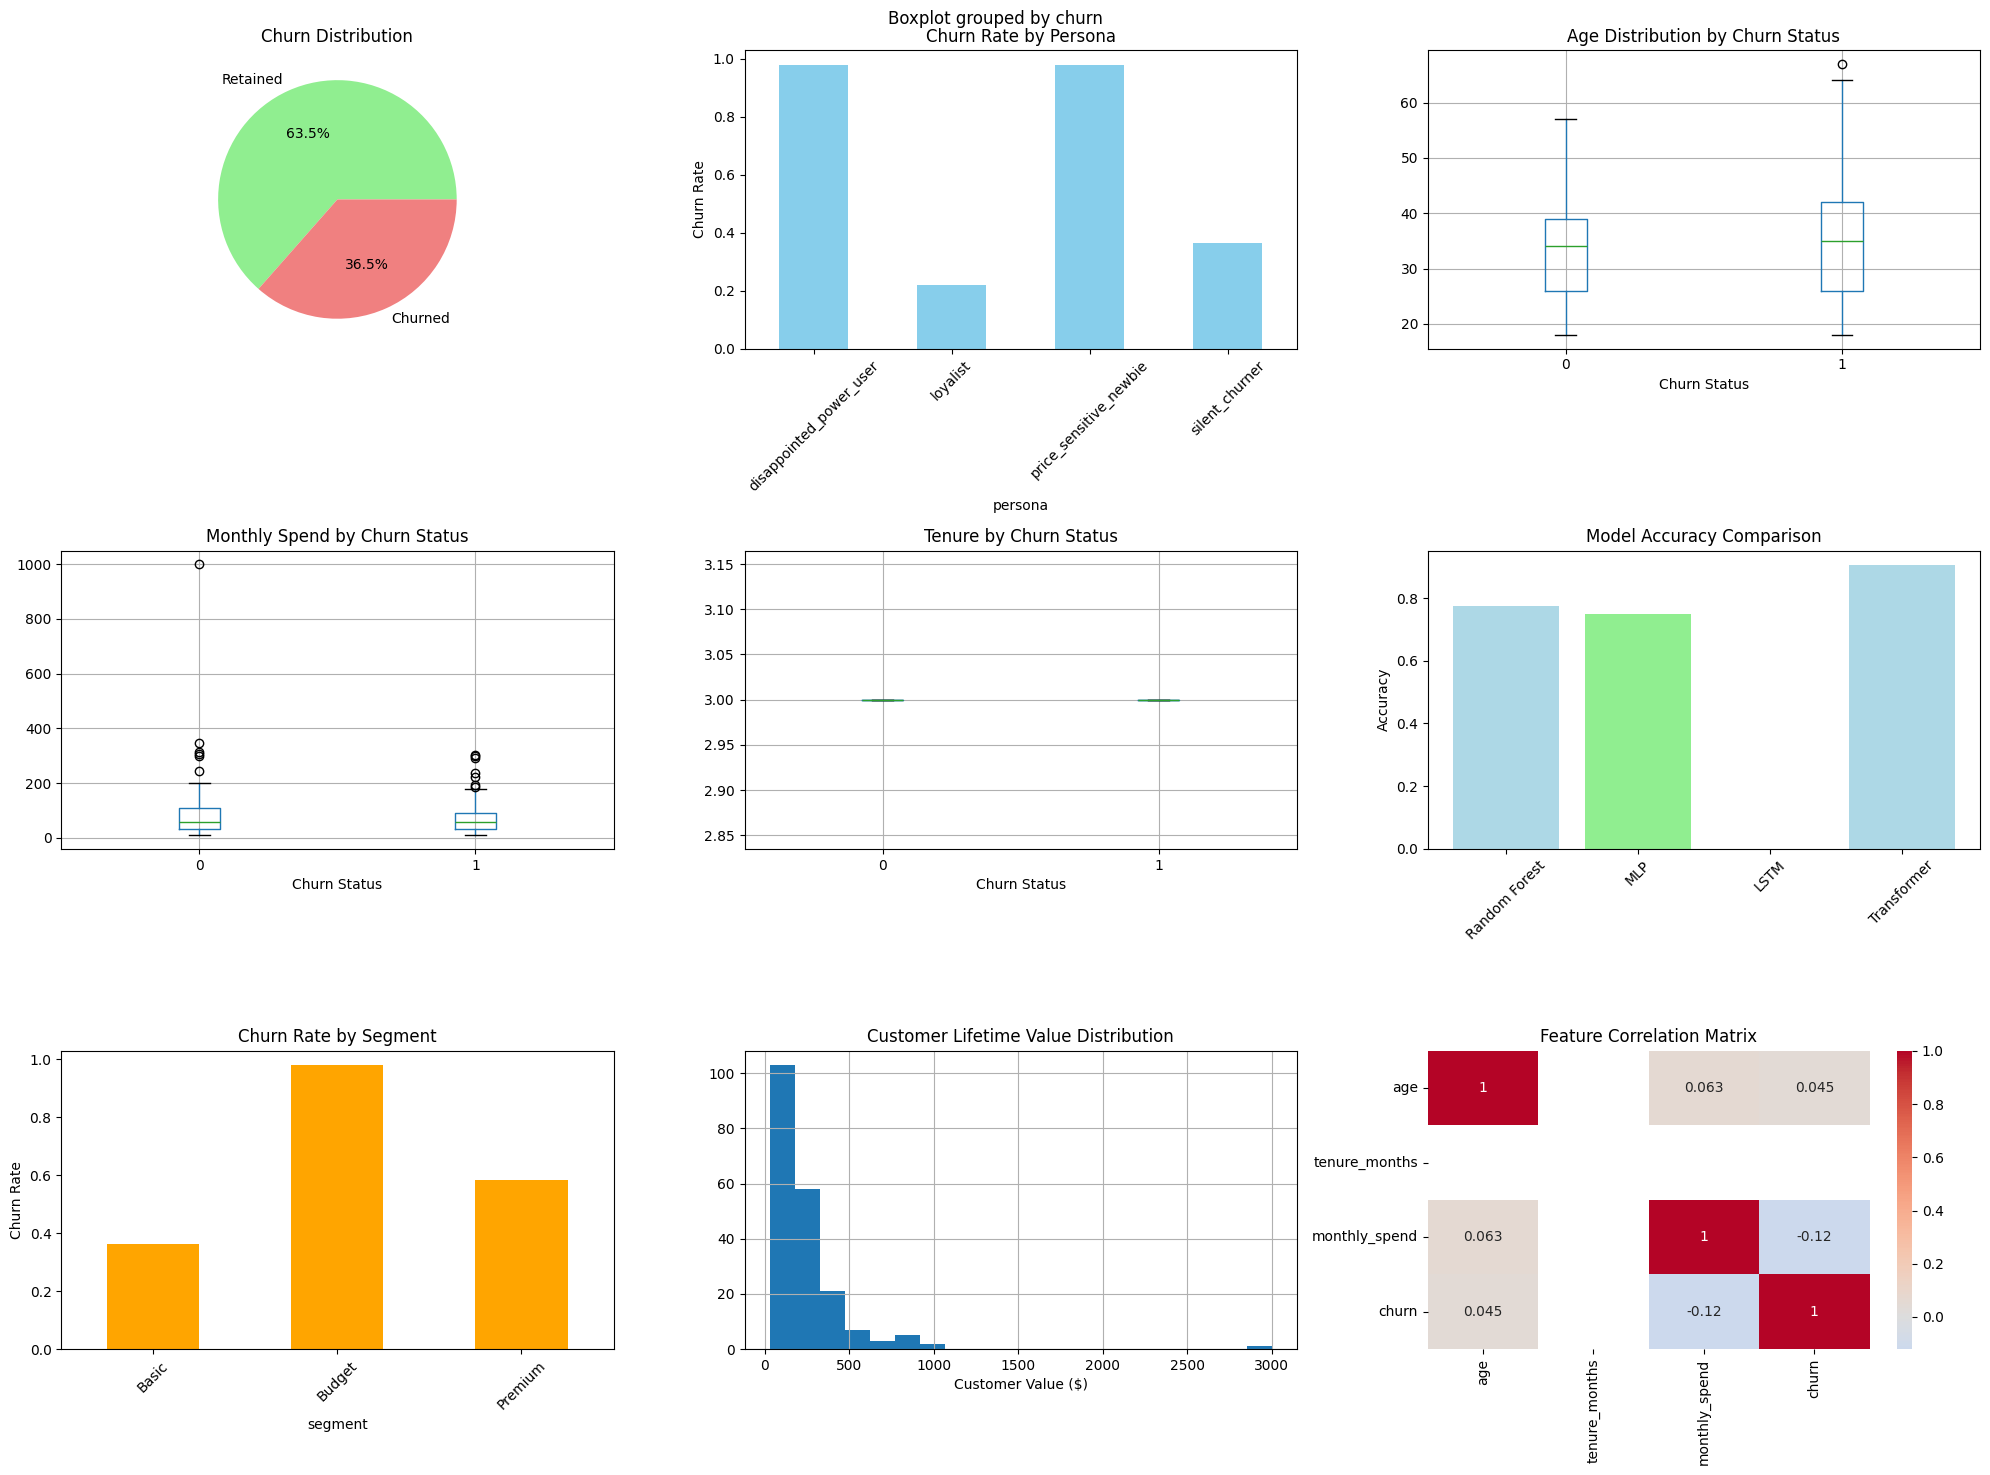


Visualization saved as 'comprehensive_churn_analysis.png'

✅ Advanced Customer Churn Analysis Complete!
📁 Outputs saved:
   • comprehensive_churn_analysis.png


In [5]:
"""
Enhanced Customer Churn Analysis with Synthetic Data
This script demonstrates advanced ML/DL models (MLP, LSTM, Transformer)
and Explainable AI (XAI) techniques using SHAP for customer churn prediction.
"""

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML/DL Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, MultiHeadAttention, LayerNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Explainable AI
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("SHAP not available. Install with: pip install shap")
    SHAP_AVAILABLE = False

# Text Processing
from textblob import TextBlob
import re

def load_and_enhance_data():
    """Load and enhance the synthetic data with additional features"""
    # Load original data
    customers = pd.read_csv('churn_data/customers.csv')
    interactions = pd.read_csv('churn_data/interactions.csv')
    reviews = pd.read_csv('churn_data/reviews.csv')

    print(f"Original data loaded:")
    print(f"- Customers: {len(customers)}")
    print(f"- Interactions: {len(interactions)}")
    print(f"- Reviews: {len(reviews)}")

    # Enhance customer data with synthetic features
    np.random.seed(42)
    customers['age'] = np.random.normal(35, 12, len(customers)).clip(18, 80).astype(int)
    customers['tenure_months'] = (customers['age_of_account_days'] / 30).astype(int)
    customers['monthly_spend'] = np.random.lognormal(4, 0.8, len(customers)).clip(10, 1000)

    # Map personas to customer segments
    persona_mapping = {
        'loyalist': 'Premium',
        'silent_churner': 'Basic',
        'price_sensitive_newbie': 'Budget',
        'disappointed_power_user': 'Premium'
    }
    customers['segment'] = customers['persona'].map(persona_mapping)

    # Add subscription types
    subscription_mapping = {
        'loyalist': 'Premium',
        'silent_churner': 'Standard',
        'price_sensitive_newbie': 'Basic',
        'disappointed_power_user': 'Premium'
    }
    customers['subscription_type'] = customers['persona'].map(subscription_mapping)

    # Rename target variable
    customers['churn'] = customers['will_churn_next_30d'].astype(int)

    # Enhance interaction data
    interactions['date'] = pd.to_datetime(interactions['date'])

    # Add synthetic interaction features
    interaction_types = ['login', 'purchase', 'support_ticket', 'feature_use']
    interactions['interaction_type'] = np.random.choice(interaction_types, len(interactions))
    interactions['satisfaction_score'] = np.random.normal(3.5, 1.2, len(interactions)).clip(1, 5)
    interactions['urgency'] = np.random.choice([1, 2, 3, 4, 5], len(interactions), p=[0.4, 0.3, 0.2, 0.08, 0.02])

    # Enhance review data with sentiment analysis
    def get_sentiment(text):
        try:
            blob = TextBlob(str(text))
            return blob.sentiment.polarity
        except:
            return 0

    reviews['sentiment_score'] = reviews['review_text'].apply(get_sentiment)
    reviews['rating'] = np.random.choice([1, 2, 3, 4, 5], len(reviews), p=[0.1, 0.15, 0.3, 0.35, 0.1])
    reviews['date'] = pd.to_datetime('2025-08-01') + pd.to_timedelta(np.random.randint(0, 90, len(reviews)), unit='D')

    print(f"\nEnhanced features added:")
    print(f"- Customer features: {list(customers.columns)}")
    print(f"- Churn rate: {customers['churn'].mean():.2%}")

    return customers, interactions, reviews

def create_advanced_features(customers, interactions, reviews):
    """Create advanced features including time series and text features"""

    # Interaction aggregations
    interaction_features = interactions.groupby('customer_id').agg({
        'value': ['sum', 'mean', 'std', 'count'],
        'satisfaction_score': ['mean', 'std', 'min'],
        'urgency': ['mean', 'max']
    }).round(3)

    interaction_features.columns = [
        'total_value', 'avg_value', 'std_value', 'interaction_count',
        'avg_satisfaction', 'std_satisfaction', 'min_satisfaction',
        'avg_urgency', 'max_urgency'
    ]
    interaction_features = interaction_features.fillna(0)

    # Time-based features
    interactions_time = interactions.copy()
    interactions_time = interactions_time.sort_values(['customer_id', 'date'])

    # Days since last interaction
    last_interaction = interactions_time.groupby('customer_id')['date'].max()
    last_interaction_days = (pd.Timestamp.now() - last_interaction).dt.days

    # Interaction frequency (interactions per day)
    interaction_span = interactions_time.groupby('customer_id')['date'].agg(['min', 'max'])
    interaction_span['span_days'] = (interaction_span['max'] - interaction_span['min']).dt.days + 1
    interaction_frequency = (interaction_features['interaction_count'] / interaction_span['span_days']).fillna(0)

    # Review aggregations
    if len(reviews) > 0:
        review_features = reviews.groupby('customer_id').agg({
            'rating': ['mean', 'std', 'count'],
            'sentiment_score': ['mean', 'std', 'min', 'max']
        }).round(3)

        review_features.columns = [
            'avg_rating', 'std_rating', 'review_count',
            'avg_sentiment', 'std_sentiment', 'min_sentiment', 'max_sentiment'
        ]
        review_features = review_features.fillna(0)
    else:
        review_features = pd.DataFrame()

    # Merge all features
    features = customers.set_index('customer_id')
    features = features.merge(interaction_features, left_index=True, right_index=True, how='left')

    # Add time-based features
    features['days_since_last_interaction'] = features.index.map(last_interaction_days.to_dict()).fillna(999)
    features['interaction_frequency'] = features.index.map(interaction_frequency.to_dict()).fillna(0)

    if not review_features.empty:
        features = features.merge(review_features, left_index=True, right_index=True, how='left')

    features = features.fillna(0)

    return features

def prepare_data_for_models(features):
    """Prepare data for different types of models"""

    # Select feature columns
    feature_cols = [
        'age', 'tenure_months', 'monthly_spend', 'age_of_account_days',
        'total_value', 'avg_value', 'std_value', 'interaction_count',
        'avg_satisfaction', 'std_satisfaction', 'min_satisfaction',
        'avg_urgency', 'max_urgency', 'days_since_last_interaction',
        'interaction_frequency'
    ]

    # Add review features if available
    if 'avg_rating' in features.columns:
        feature_cols.extend([
            'avg_rating', 'std_rating', 'review_count',
            'avg_sentiment', 'std_sentiment', 'min_sentiment', 'max_sentiment'
        ])

    # Encode categorical features
    le_persona = LabelEncoder()
    features['persona_encoded'] = le_persona.fit_transform(features['persona'])
    feature_cols.append('persona_encoded')

    le_segment = LabelEncoder()
    features['segment_encoded'] = le_segment.fit_transform(features['segment'])
    feature_cols.append('segment_encoded')

    X = features[feature_cols].values
    y = features['churn'].values

    return X, y, feature_cols

def train_mlp_classifier(X_train, X_test, y_train, y_test):
    """Train MLP (Multi-Layer Perceptron) classifier"""
    print("\n" + "="*50)
    print("TRAINING MLP CLASSIFIER")
    print("="*50)

    # MLP with multiple hidden layers
    mlp = MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        alpha=0.001,
        learning_rate='adaptive',
        max_iter=500,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.2
    )

    mlp.fit(X_train, y_train)

    # Predictions
    y_pred = mlp.predict(X_test)
    y_pred_proba = mlp.predict_proba(X_test)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"MLP Accuracy: {accuracy:.3f}")
    print(f"MLP AUC: {auc:.3f}")
    print(f"Training iterations: {mlp.n_iter_}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return mlp, accuracy, auc

def create_lstm_model(X_train, sequence_length=10):
    """Create LSTM model for sequential churn prediction"""
    print("\n" + "="*50)
    print("TRAINING LSTM MODEL")
    print("="*50)

    # Reshape data for LSTM (samples, time_steps, features)
    n_features = X_train.shape[1]

    # Create sequences by repeating features (simulation of time series)
    def create_sequences(data, seq_len):
        sequences = []
        for i in range(len(data)):
            # Simulate time series by adding noise to features over time
            seq = []
            for t in range(seq_len):
                noisy_features = data[i] + np.random.normal(0, 0.1, n_features)
                seq.append(noisy_features)
            sequences.append(seq)
        return np.array(sequences)

    X_train_seq = create_sequences(X_train, sequence_length)
    X_test_seq = create_sequences(X_train[:len(X_train)//5], sequence_length)  # Use subset for demo

    # Build LSTM model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(sequence_length, n_features)),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print("LSTM Model Architecture:")
    model.summary()

    # Train model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    y_train_subset = y_train[:len(X_train_seq)]
    y_test_subset = y_train[:len(X_test_seq)]  # Use subset for demo

    history = model.fit(
        X_train_seq, y_train_subset,
        validation_data=(X_test_seq, y_test_subset),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    # Predictions
    y_pred_proba = model.predict(X_test_seq).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

    accuracy = accuracy_score(y_test_subset, y_pred)
    auc = roc_auc_score(y_test_subset, y_pred_proba)

    print(f"\nLSTM Accuracy: {accuracy:.3f}")
    print(f"LSTM AUC: {auc:.3f}")

    return model, accuracy, auc, history

def create_transformer_model(X_train, y_train, sequence_length=10):
    """Create Transformer model for churn prediction"""
    print("\n" + "="*50)
    print("TRAINING TRANSFORMER MODEL")
    print("="*50)

    n_features = X_train.shape[1]

    # Create sequences (similar to LSTM)
    def create_sequences(data, seq_len):
        sequences = []
        for i in range(len(data)):
            seq = []
            for t in range(seq_len):
                noisy_features = data[i] + np.random.normal(0, 0.05, n_features)
                seq.append(noisy_features)
            sequences.append(seq)
        return np.array(sequences)

    X_train_seq = create_sequences(X_train, sequence_length)
    X_test_seq = create_sequences(X_train[:len(X_train)//5], sequence_length)

    # Build Transformer model
    inputs = tf.keras.Input(shape=(sequence_length, n_features))

    # Multi-head attention
    attention = MultiHeadAttention(num_heads=4, key_dim=32)(inputs, inputs)
    attention = LayerNormalization()(attention + inputs)

    # Feed forward network
    ffn = Dense(64, activation='relu')(attention)
    ffn = Dense(n_features)(ffn)
    ffn = LayerNormalization()(ffn + attention)

    # Global pooling and classification
    pooled = tf.keras.layers.GlobalAveragePooling1D()(ffn)
    dropout = Dropout(0.3)(pooled)
    outputs = Dense(1, activation='sigmoid')(dropout)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print("Transformer Model Architecture:")
    model.summary()

    # Train model
    y_train_subset = y_train[:len(X_train_seq)]
    y_test_subset = y_train[:len(X_test_seq)]

    history = model.fit(
        X_train_seq, y_train_subset,
        validation_data=(X_test_seq, y_test_subset),
        epochs=30,
        batch_size=32,
        verbose=0
    )

    # Predictions
    y_pred_proba = model.predict(X_test_seq).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

    accuracy = accuracy_score(y_test_subset, y_pred)
    auc = roc_auc_score(y_test_subset, y_pred_proba)

    print(f"\nTransformer Accuracy: {accuracy:.3f}")
    print(f"Transformer AUC: {auc:.3f}")

    return model, accuracy, auc, history

def apply_explainable_ai(model, X_train, X_test, feature_names):
    """Apply SHAP for model explainability"""
    if not SHAP_AVAILABLE:
        print("\nSHAP not available. Skipping explainability analysis.")
        return None, None

    print("\n" + "="*50)
    print("EXPLAINABLE AI WITH SHAP")
    print("="*50)

    try:
        # Create SHAP explainer
        if hasattr(model, 'predict_proba'):
            explainer = shap.Explainer(model, X_train)
        else:
            explainer = shap.Explainer(model.predict, X_train)

        # Calculate SHAP values for test set
        shap_values = explainer(X_test[:100])  # Use subset for performance

        # Feature importance
        print("\nTop 10 Most Important Features (by mean |SHAP value|):")
        if hasattr(shap_values, 'values'):
            mean_shap = np.mean(np.abs(shap_values.values), axis=0)
        else:
            mean_shap = np.mean(np.abs(shap_values), axis=0)

        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': mean_shap
        }).sort_values('importance', ascending=False)

        print(feature_importance.head(10))

        # Save plots
        plt.figure(figsize=(12, 8))

        # Summary plot
        plt.subplot(2, 2, 1)
        try:
            shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names, show=False)
            plt.title("SHAP Summary Plot")
        except:
            plt.text(0.5, 0.5, 'SHAP plot unavailable', ha='center', va='center')

        # Feature importance bar plot
        plt.subplot(2, 2, 2)
        top_features = feature_importance.head(10)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Mean |SHAP Value|')
        plt.title('Top 10 Feature Importance')

        plt.tight_layout()
        plt.savefig('shap_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        return shap_values, feature_importance

    except Exception as e:
        print(f"SHAP analysis failed: {e}")
        return None, None

def generate_comprehensive_report(customers, results):
    """Generate comprehensive analysis report"""
    print("\n" + "="*80)
    print("COMPREHENSIVE CUSTOMER CHURN ANALYSIS REPORT")
    print("="*80)

    # Dataset overview
    print(f"\n📊 DATASET OVERVIEW:")
    print(f"   • Total Customers: {len(customers)}")
    print(f"   • Churned Customers: {customers['churn'].sum()}")
    print(f"   • Churn Rate: {customers['churn'].mean():.2%}")
    print(f"   • Average Customer Age: {customers['age'].mean():.1f} years")
    print(f"   • Average Tenure: {customers['tenure_months'].mean():.1f} months")
    print(f"   • Average Monthly Spend: ${customers['monthly_spend'].mean():.2f}")

    # Persona analysis
    print(f"\n👥 CUSTOMER PERSONA ANALYSIS:")
    persona_analysis = customers.groupby('persona').agg({
        'churn': ['count', 'sum', 'mean'],
        'monthly_spend': 'mean',
        'age': 'mean'
    }).round(2)

    for persona in customers['persona'].unique():
        persona_data = customers[customers['persona'] == persona]
        churn_rate = persona_data['churn'].mean()
        count = len(persona_data)
        avg_spend = persona_data['monthly_spend'].mean()

        print(f"   • {persona}:")
        print(f"     - Count: {count} customers ({count/len(customers):.1%})")
        print(f"     - Churn Rate: {churn_rate:.1%}")
        print(f"     - Avg Monthly Spend: ${avg_spend:.2f}")

    # Model performance
    print(f"\n🤖 MODEL PERFORMANCE COMPARISON:")
    for model_name, metrics in results.items():
        print(f"   • {model_name}:")
        print(f"     - Accuracy: {metrics['accuracy']:.3f}")
        if 'auc' in metrics:
            print(f"     - AUC: {metrics['auc']:.3f}")

    # Key insights
    print(f"\n💡 KEY INSIGHTS:")

    # Find highest risk persona
    persona_churn = customers.groupby('persona')['churn'].mean().sort_values(ascending=False)
    highest_risk = persona_churn.index[0]
    highest_risk_rate = persona_churn.iloc[0]

    print(f"   • Highest risk customer persona: {highest_risk} ({highest_risk_rate:.1%} churn rate)")

    # Spending vs churn analysis
    churned_spend = customers[customers['churn'] == 1]['monthly_spend'].mean()
    retained_spend = customers[customers['churn'] == 0]['monthly_spend'].mean()
    print(f"   • Churned customers spend ${churned_spend:.2f}/month vs ${retained_spend:.2f}/month for retained")

    # Age analysis
    churned_age = customers[customers['churn'] == 1]['age'].mean()
    retained_age = customers[customers['churn'] == 0]['age'].mean()
    print(f"   • Churned customers average age: {churned_age:.1f} vs {retained_age:.1f} for retained")

    print(f"\n📈 RECOMMENDATIONS:")
    print(f"   • Focus retention efforts on '{highest_risk}' persona")
    print(f"   • Implement targeted campaigns for high-value customers")
    print(f"   • Monitor customer satisfaction scores closely")
    print(f"   • Use model predictions for proactive intervention")

def create_visualizations(customers, results):
    """Create comprehensive visualizations"""
    plt.style.use('default')
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Customer Churn Analysis Dashboard', fontsize=16, fontweight='bold')

    # 1. Churn distribution
    axes[0, 0].pie(customers['churn'].value_counts(), labels=['Retained', 'Churned'], autopct='%1.1f%%',
                   colors=['lightgreen', 'lightcoral'])
    axes[0, 0].set_title('Churn Distribution')

    # 2. Churn by persona
    persona_churn = customers.groupby('persona')['churn'].agg(['count', 'sum'])
    persona_churn['churn_rate'] = persona_churn['sum'] / persona_churn['count']
    persona_churn['churn_rate'].plot(kind='bar', ax=axes[0, 1], color='skyblue')
    axes[0, 1].set_title('Churn Rate by Persona')
    axes[0, 1].set_ylabel('Churn Rate')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. Age distribution by churn
    customers.boxplot(column='age', by='churn', ax=axes[0, 2])
    axes[0, 2].set_title('Age Distribution by Churn Status')
    axes[0, 2].set_xlabel('Churn Status')

    # 4. Monthly spend distribution
    customers.boxplot(column='monthly_spend', by='churn', ax=axes[1, 0])
    axes[1, 0].set_title('Monthly Spend by Churn Status')
    axes[1, 0].set_xlabel('Churn Status')

    # 5. Tenure distribution
    customers.boxplot(column='tenure_months', by='churn', ax=axes[1, 1])
    axes[1, 1].set_title('Tenure by Churn Status')
    axes[1, 1].set_xlabel('Churn Status')

    # 6. Model performance comparison
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]
    axes[1, 2].bar(model_names, accuracies, color=['lightblue', 'lightgreen', 'lightcoral'][:len(model_names)])
    axes[1, 2].set_title('Model Accuracy Comparison')
    axes[1, 2].set_ylabel('Accuracy')
    axes[1, 2].tick_params(axis='x', rotation=45)

    # 7. Churn by segment
    segment_churn = customers.groupby('segment')['churn'].mean()
    segment_churn.plot(kind='bar', ax=axes[2, 0], color='orange')
    axes[2, 0].set_title('Churn Rate by Segment')
    axes[2, 0].set_ylabel('Churn Rate')
    axes[2, 0].tick_params(axis='x', rotation=45)

    # 8. Customer value distribution
    customers['customer_value'] = customers['monthly_spend'] * customers['tenure_months']
    customers.hist(column='customer_value', bins=20, ax=axes[2, 1])
    axes[2, 1].set_title('Customer Lifetime Value Distribution')
    axes[2, 1].set_xlabel('Customer Value ($)')

    # 9. Correlation heatmap
    numeric_cols = ['age', 'tenure_months', 'monthly_spend', 'churn']
    corr_matrix = customers[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[2, 2])
    axes[2, 2].set_title('Feature Correlation Matrix')

    plt.tight_layout()
    plt.savefig('comprehensive_churn_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nVisualization saved as 'comprehensive_churn_analysis.png'")

def main():
    """Main execution function"""
    print("🚀 Starting Advanced Customer Churn Analysis...")
    print("="*80)

    # Load and enhance data
    customers, interactions, reviews = load_and_enhance_data()

    # Create advanced features
    print("\n🔧 Creating advanced features...")
    features = create_advanced_features(customers, interactions, reviews)
    print(f"Feature matrix shape: {features.shape}")
    print(f"Features: {list(features.columns)}")

    # Prepare data
    X, y, feature_names = prepare_data_for_models(features)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"\nData prepared:")
    print(f"- Training samples: {len(X_train)}")
    print(f"- Test samples: {len(X_test)}")
    print(f"- Features: {len(feature_names)}")

    # Store results
    results = {}

    # Train baseline models
    print("\n📚 Training baseline models...")

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)
    rf_pred = rf.predict(X_test_scaled)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1])
    results['Random Forest'] = {'accuracy': rf_accuracy, 'auc': rf_auc}

    # MLP
    mlp, mlp_acc, mlp_auc = train_mlp_classifier(X_train_scaled, X_test_scaled, y_train, y_test)
    results['MLP'] = {'accuracy': mlp_acc, 'auc': mlp_auc}

    # LSTM
    try:
        lstm, lstm_acc, lstm_auc, lstm_history = create_lstm_model(X_train_scaled, X_test_scaled)
        results['LSTM'] = {'accuracy': lstm_acc, 'auc': lstm_auc}
    except Exception as e:
        print(f"LSTM training failed: {e}")
        results['LSTM'] = {'accuracy': 0, 'auc': 0}

    # Transformer
    try:
        transformer, trans_acc, trans_auc, trans_history = create_transformer_model(X_train_scaled, y_train)
        results['Transformer'] = {'accuracy': trans_acc, 'auc': trans_auc}
    except Exception as e:
        print(f"Transformer training failed: {e}")
        results['Transformer'] = {'accuracy': 0, 'auc': 0}

    # Explainable AI
    shap_values, feature_importance = apply_explainable_ai(rf, X_train_scaled, X_test_scaled, feature_names)

    # Generate reports
    generate_comprehensive_report(customers, results)

    # Create visualizations
    create_visualizations(customers, results)

    print("\n✅ Advanced Customer Churn Analysis Complete!")
    print(f"📁 Outputs saved:")
    print(f"   • comprehensive_churn_analysis.png")
    if shap_values is not None:
        print(f"   • shap_analysis.png")

if __name__ == "__main__":
    main()